In [11]:
import numpy as np
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Activation
from keras.layers import TimeDistributed, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from keras import backend as K

raw = open('data_training_alo', 'r').readlines()

all_x = []
point = []
for line in raw:
    stripped_line = line.strip().split('\t')
    if len(stripped_line) == 2:
        point.append(stripped_line)
    if line == '\n':
        all_x.append(point[:-1])
        point = []
all_x = all_x[:-1]

In [12]:
print(all_x)

[[['dok ', 'O'], ['penumpukan', 'B-DISEASE'], ['cairan', 'I-DISEASE'], ['di', 'B-BBODY'], ['otak', 'I-BBODY'], ['di ', 'O'], ['sebabkan ', 'O'], ['karena ', 'O']], [['malam ', 'O'], ['dok ', 'O'], ['saya ', 'O'], ['berumur ', 'O'], ['17', 'B-CHILD'], ['tahun', 'I-CHILD'], ['2 ', 'O'], ['minggu ', 'O'], ['yang ', 'O'], ['lalau ', 'O'], ['saya ', 'O'], ['terkena ', 'O'], ['gejala ', 'O'], ['pada ', 'O'], ['usus', 'B-DISEASE'], ['buntu', 'I-DISEASE'], ['hanya ', 'O'], ['infeksi', 'B-DISEASE'], ['tetapi ', 'O'], ['dokter ', 'O'], ['tidak ', 'O'], ['menyarankan ', 'O'], ['saya ', 'O'], ['untuk ', 'O'], ['operasi ', 'O'], ['saya ', 'O'], ['di', 'B-TREATMENT'], ['impus', 'I-TREATMENT'], ['2 ', 'O'], ['hari ', 'O'], ['dan ', 'O'], ['telah ', 'O'], ['minum ', 'O'], ['obat ', 'O'], ['10 ', 'O'], ['hari ', 'O'], ['saya ', 'O'], ['ingin ', 'O'], ['bertanya ', 'O'], ['apa ', 'O'], ['langkah ', 'O'], ['selanjutnya ', 'O'], ['yg ', 'O'], ['harus ', 'O'], ['saya ', 'O'], ['lakukan ', 'O'], ['agar ', '

In [13]:
lengths = [len(x) for x in all_x]
print ('Input sequence length range: ', max(lengths), min(lengths))

short_x = [x for x in all_x if len(x) < 100]

X = [[c[0] for c in x] for x in short_x]
y = [[c[1] for c in y] for y in short_x]

all_text = [c for x in X for c in x]

Input sequence length range:  134 0


In [65]:
import json

# X_train
words = list(set(all_text))
word2ind = {word: index for index, word in enumerate(words)}
# ind2word = {index: word for index, word in enumerate(words)}
with open('./model-ner/dictionary-x.json','w') as dict_x:
    json.dump(word2ind, dict_x)

# y_train, coba diganti dengan label encoder supaya gampang di predict pake argmax
labels = list(set([c for x in y for c in x]))
# label2ind = {label: (index + 1) for index, label in enumerate(labels)}
ind2label = {(index + 1): label for index, label in enumerate(labels)}
with open('./model-ner/dictionary-y.json','w') as dict_y:
    json.dump(ind2label, dict_y)
print ('Vocabulary size:', len(word2ind), len(label2ind))

maxlen = max([len(x) for x in X])
print ('Maximum sequence length:', maxlen)
print(label2ind)
print(word2ind)

def encode(x, n):
    result = np.zeros(n)
    result[x] = 1
    return result

X_enc = [[word2ind[c] for c in x] for x in X]
max_label = max(label2ind.values()) + 1
y_enc = [[0] * (maxlen - len(ey)) + [label2ind[c] for c in ey] for ey in y]
y_enc = [[encode(c, max_label) for c in ey] for ey in y_enc]

X_train = pad_sequences(X_enc, maxlen=maxlen)
y_train = pad_sequences(y_enc, maxlen=maxlen)

Vocabulary size: 13022 41
Maximum sequence length: 94
{'B-BABY': 1, 'I-LACTATION': 2, 'B-ADULT': 3, 'B-PRIMARY': 4, 'B-DURATION': 5, 'B-BBODY': 6, 'B-DISEASE': 7, 'I-FOOD': 8, 'I-ADULT': 9, 'B-LACTATION': 10, 'I-ANTISYMPTOM': 11, 'I-TREATMENT': 12, 'B-SOMEONE': 13, 'I-TEST': 14, 'I-ACTIVITY': 15, 'I-PRIMARY': 16, 'I-PROMIL': 17, 'B-WOMAN': 18, 'I-DISEASE': 19, 'I-SYMPTOM': 20, 'I-WOMAN': 21, 'B-FOOD': 22, 'B-ACIVITY': 23, 'B-SYMPTOM': 24, 'I-MAN': 25, 'B-PREGNANT': 26, 'I-CHILD': 27, 'B-TREATMENT': 28, 'I-DURATION': 29, 'B-PREGANT': 30, 'I-BBODY': 31, 'B-TEST': 32, 'I-SOMEONE': 33, 'B-ANTISYMPTOM': 34, 'I-PREGNANT': 35, 'O': 36, 'B-PROMIL': 37, 'B-MAN': 38, 'B-CHILD': 39, 'B-ACTIVITY': 40, 'I-BABY': 41}
{'23cm ': 0, 'naik"': 1, 'tenggorokan': 2, 'berenang': 3, 'menandakan ': 4, '40kg ': 5, 'gringging': 6, 'berminyak, ': 7, 'hilang.. ': 8, 'sengaja ': 9, 'obat" ': 10, 'bawa ': 11, 'dahsyat ': 12, 'berbahaya ': 13, 'naik2': 14, 'memberi ': 15, 'dikaki': 16, 'invitec': 17, 'merasakan ': 1

In [23]:
print(X_train)

[[    0     0     0 ...  9679  1343 12890]
 [    0     0     0 ...  8330  2014  7310]
 [    0     0     0 ...  9809 12773  1180]
 ...
 [    0     0     0 ...  2995 10545  5322]
 [    0     0     0 ... 12706  2995  9702]
 [    0     0     0 ...  9846  5525   416]]


In [38]:
from keras.callbacks import ModelCheckpoint

max_features = len(word2ind)
embedding_size = 128
hidden_size = 32
out_size = len(label2ind) + 1

model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen, mask_zero=True))
model.add(LSTM(hidden_size, return_sequences=True))  
model.add(TimeDistributed(Dense(out_size)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpointer = ModelCheckpoint('./model-ner/model.hdf5',save_best_only=True, verbose=1)
model.summary()
batch_size = 32
model.fit(X_train, y_train, batch_size=batch_size, epochs=10, validation_split = 0.2, callbacks = [checkpointer])


# save model json
model_json = model.to_json()
with open('./model-ner/sub-model.json', 'w') as json_file: # tidak bisa pakai json.dump karena isinya banyak \ \
    json_file.write(model_json)

# score = model.evaluate(X_test, y_test, batch_size=batch_size)
# print('Raw test score:', score)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 94, 128)           1666816   
_________________________________________________________________
lstm_2 (LSTM)                (None, 94, 32)            20608     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 94, 42)            1386      
_________________________________________________________________
activation_2 (Activation)    (None, 94, 42)            0         
Total params: 1,688,810
Trainable params: 1,688,810
Non-trainable params: 0
_________________________________________________________________


/home/handy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 1440 arrays: [array([[7398],
       [3612],
       [7614],
       [1659],
       [7398],
       [4634],
       [9852],
       [2995]]), array([[ 3926],
       [10545],
       [ 5322],
       [ 5938],
       [ 1948...

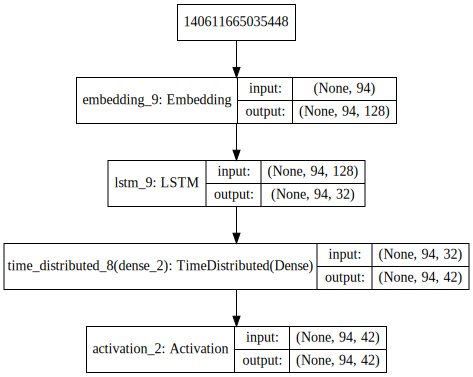

In [46]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [64]:
string = "dok penumpukan cairan di otak di sebabkan karena apa"
wordlist = string.split(' ')
ip = []
for x in wordlist:
    if x in word2ind:
        ip.append(word2ind[x])
i=maxlen-len(ip)
temp=[0]*i
ip=temp+ip
print(ip)
print(len(ip))
op = K.function([model.layers[0].input], model.layers[3].output)
out = op([[ip]])
temp = []
while i<maxlen:
    for j in label2ind:
        if label2ind[j]==out[0][i].tolist().index(max(out[0][i])):
            temp.append(j)
    i=i+1
print(wordlist)
print(temp)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12376, 9229, 7104, 4810, 11252, 4810, 5366, 9508]
94


TypeError: `outputs` of a TensorFlow backend function should be a list or tuple.

In [78]:
import keras.preprocessing.text as kpt
import json
from keras.models import model_from_json

def load(string):
    max_input = 94
    # load dictionary
    with open('./model-ner/dictionary-x.json') as dict_x:
        dictionary_x = json.load(dict_x)
    
    # input
    words = [word for word in kpt.text_to_word_sequence(string) if word in dictionary_x]
    ind_dictionary = [dictionary_x[word] for word in words]
    input_ = [0]*(max_input-len(ind_dictionary))
    input_ += ind_dictionary
    
    # model
    file_model = open('./model-ner/sub-model.json')
    load_model = file_model.read()
    file_model.close()
    
    # class    
    with open('./model-ner/dictionary-y.json') as dict_y:
        dictionary_y = json.load(dict_y)
    
    model = model_from_json(load_model)
    model.load_weights('./model-ner/model.hdf5')
    
    pred = model.predict([[input_]])
    result = []
    for i in pred:
        for k, j in zip(words,i[-len(ind_dictionary):]):
            result.append((k,dictionary_y[str(np.argmax(j))]))
    
    return result
    

string = "dok penumpukan cairan di otak di sebabkan karena apa kuhl"
predict = load(string)
print(predict)


[('dok', 'I-TEST'), ('penumpukan', 'B-BABY'), ('cairan', 'B-ACIVITY'), ('di', 'I-ACTIVITY'), ('otak', 'I-TEST'), ('di', 'I-TEST'), ('sebabkan', 'I-TEST'), ('apa', 'I-TEST')]
